# 3.2 Velocity-based motion model

In the remainder of this chapter we will describe two probabilistic motion models for planar movement: the **velocity motion model** and the **odometry motion model**. In its turn, these models can be used in:

- **Analytic form**, where the robot pose at instant $t$ ($x_t$) is modelled as a probability density function (pdf), and it typically follows $x_t \sim N(\overline{x}_t,\Sigma_{x_t})$. This way is used in techniques like the Extendend Kalman Filter (EKF).

- **Sample form**, where the robot pose at instant $t$ is modelled through a set of samples $\{x_t^i\}, i=1,\dots n$, which is used in Sequential Montecarlo, also called Particle Filter.

This time we will focus on the velocity **motion model** in its **analytic form**.

Remember that when a motion command is given to a robot, there are different factors that affect such movement (*e.g.* wheel slippage, unequal floor, inaccurate calibration, motors response, etc.), adding uncertainty to the actual move done. This results in a need for characterizing the robot motion in *probabilistic terms*, that is:

$$x_t \sim p(x_t | u_t, x_{t-1})$$

being:
- $x_t$ the robot pose at time instant $t$,
- $u_t$ the motion command (also called control action) at $t$, and
- $x_{t-1}$ the robot pose at the previous time instant $t-1$.

So basically this probability models the probability distribution over robot poses when executing the motion command $u_t$, having the robot the previous pose $x_{t-1}$. In other words, we are considering a function $g(\cdot)$ that performs $x_t=g(x_{t-1},u_t)$ and outputs $x_t \sim p(x_t | u_t, x_{t-1})$: $\\[10pt]$

<figure style="text-align:center">
  <img src="images/fig3-2-probatilistic_robot_motion.png" alt="" width="400px">
  <figcaption>Fig. 1: Inputs and outputs of a probabilistic motion model.</figcaption>
</figure>


Different definitions for the $g(\cdot)$ function lead to different probabilistic motion models, like the velocity motion model explored here.

## 3.2.1 The model

<div class="alert alert-block alert-success">
    <b>Usage:</b> The <b><i>velocity motion model</i></b> is mainly used for motion planning, where the details of the robot's movement are of importance and odometry information is not available (<i>e.g.</i> no wheel encoders are available).
</div>

This motion model is characterized by the use of two velocities to control the robot's movement: **linear velocity** $v$ and **angular velocity** $w$. Therefore, during the following sections, the movement commands will be of the form: 

$$u_t = \begin{bmatrix} v_t \\ w_t \end{bmatrix}, \, \, \, u_t \sim N(\overline{u},\Sigma_{u_t})$$

The velocity motion model defines the function $g(\cdot)$ as:

$$g(x_{t-1},u_t)=x_{t-1} \oplus \Delta x_t, \, \, \,
x_{t-1}\sim N (\overline{x}_{t-1},\Sigma_{x_{t-1}})$$

being $\Delta_{x_t}=[\Delta_{x_t}, \Delta_{y_t}, \Delta_{\theta_t}]$ (assuming w and v constant):
- $\Delta x_t = \frac{v}{w} \sin(w\Delta t)$
- $\Delta y_t = \frac{v}{w} [1-\cos(w\Delta t)]$
- $\Delta \theta_t = w\Delta t$

Note that $g(x_{t-1},u_t)=x_{t-1} \oplus \Delta x_t$ **is not a linear operation!**

In this way, this motion model is characterized by the following equations, depending on the value of the angular velocity $w$ (note that a division by zero would appear in the first case if $w=0$):


- If $w \neq 0$:

    $$
        \begin{bmatrix}
        x_t \\
        y_t \\
        \theta_t \\ 
        \end{bmatrix} 
        = 
        \begin{bmatrix}
        x_{t-1} \\
        y_{t-1} \\
        \theta_{t-1} \\ 
        \end{bmatrix} 
        +
        \begin{bmatrix}
            -R \sin \theta_{t-1} + R \sin(\theta_{t-1} + \Delta \theta) \\ 
            R \cos \theta_{t-1} - R \cos(\theta_{t-1} + \Delta \theta)\\
            \Delta \theta
        \end{bmatrix}
    $$

- If $w = 0$:

    $$
       \begin{bmatrix}
        x_t \\
        y_t \\
        \theta_t \\ 
        \end{bmatrix} 
        = 
        \begin{bmatrix}
        x_{t-1} \\
        y_{t-1} \\
        \theta_{t-1} \\ 
        \end{bmatrix} 
        + v \cdot \Delta t
        \begin{bmatrix}
            \cos \theta_{t-1} \\ \sin \theta_{t-1} \\ 0
        \end{bmatrix}
    $$

with: 

- $v = w \cdot R \ $   *(R is also called the curvature radius)*
- $\Delta \theta = w \cdot  \Delta t$



In [1]:
%matplotlib widget

# IMPORTS
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time


import sys
sys.path.append("..")
from utils.DrawRobot import DrawRobot
from utils.PlotEllipse import PlotEllipse

### **<span style="color:green"><b><i>ASSIGNMENT 1: The model in action</i></b></span>**

Modify the following `next_pose()` function, used in the `VelocityRobot` class below, which computes the next pose $x_t$ of a robot given:
- its previous pose $x_{t-1}$, 
- the velocity movement command $u=[v,w]^T$, and
- a lapse of time $\Delta t$. 

Concretly you have to complete the if-else statement that takes into account when the robot moves in an straight line so $w = 0$. 
*Note: you don't have to modify the `None` in the function header nor in the `if cov is not None:` condition.*

Remark that at this point **we are not taking into account uncertainty in the system**: neither from the initial pose ($\Sigma_{x_{t-1}}$) nor the movement $(v, w)$ ($\Sigma_{u_{t}}$).

**Example**

<figure style="text-align:center">
  <img src="images/fig3-2-1.png" alt="">
  <figcaption>Fig. 2: Route of our robot.</figcaption>
</figure>

In [2]:
def next_pose(x, u, dt, cov=None):
    ''' This function takes pose x and transform it according to the motion u=[v,w]'
        applying the differential drive model.

        Args:
            x: current pose
            u: differential command as a vector [v, w]'
            dt: Time interval in which the movement occurs
            cov: covariance of our movement. If not None, then add gaussian noise
    '''
    if cov is not None:
        u += np.sqrt(cov) @ random.randn(2, 1)
        #u = np.random.multivariate_normal(u.flatten(),cov)

    if u[1] == 0: #linear motion w=0
        theta = x[2]
        v = u[0]
        next_x = x + v*dt*np.vstack([np.cos(theta),
                       np.sin(theta),
                       0])
    else: #Non-linear motion w=!0
        R = u[0]/u[1] # v/w = R is the curvature radius
        theta = x[2]
        dt_theta = dt*u[1]
        next_x = x + np.vstack([-R*np.sin(theta) + R*np.sin(theta + dt_theta),
                       R*np.cos(theta) - R*np.cos(theta + dt_theta),
                       dt_theta])

    return next_x

In [3]:
class VelocityRobot(object):
    """ Mobile robot implementation that uses velocity commands.
    
        Attr:
            pose: expected pose of the robot in the real world (without taking account noise)
            dt: Duration of each step in seconds
    """    
    def __init__(self, mean, dt):
        self.pose = mean
        self.dt = dt
        
    def step(self, u):
        self.pose = next_pose(self.pose, u, self.dt)
        
    def draw(self, fig, ax):
        DrawRobot(fig, ax, self.pose)

**Test the movement of your robot** using the demo below.

In [4]:
def main(robot, nSteps):
          
    v = 1 # Linear Velocity 
    l = 0.5 #Half the width of the robot
        
    # MATPLOTLIB
    fig, ax = plt.subplots()
    plt.ion()
    fig.canvas.draw()
    plt.xlim((-2, 20))
    plt.ylim((-2, 30))
    plt.fill([7.5, 7.5, 16, 16, 20, 20],[-2, 7.5, 7.5, 20, 20, -2],
             facecolor='lightgray', edgecolor='gray', linewidth=3)
    plt.fill([-3, 0, 0, 7.5, 7.5, -3],[5, 5, 17.5, 17.5, 32, 32],
             facecolor='lightgray', edgecolor='gray', linewidth=3)
    
    plt.grid()
        
    # MAIN LOOP
    for k in range(1, nSteps + 1):
        #control is a wiggle with constant linear velocity
        u = np.vstack((v, np.pi / 10 * np.sin(4 * np.pi * k/nSteps)))
        
        robot.step(u)   
        
        #draw occasionally
        if (k-1)%20 == 0:
            robot.draw(fig, ax)
            clear_output(wait=True)
            display(fig)        
            time.sleep(0.1)
            
    plt.close()


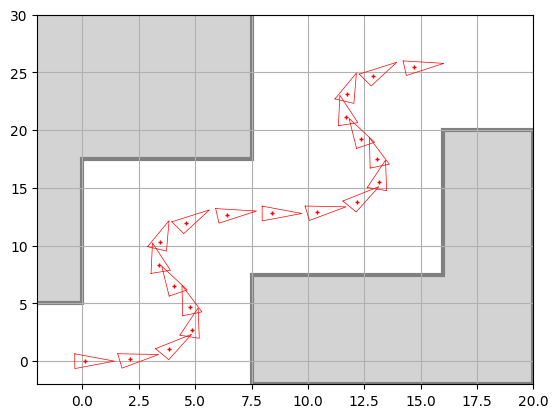

In [5]:
# RUN 
dT = 0.1 # time steps size
pose = np.vstack([0., 0., 0.])

robot = VelocityRobot(pose, dT)
main(robot, nSteps=400)

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Now that you have some experience with robot motion and the velocity motion model, **answer the following questions**:

- Why do we need to consider two different cases when applying the $g(\cdot)$ function, that is, calculating the new robot pose?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Los casos considerados se distinguen en si la velocidad angular $w$ es igual o no a 0. Necesitamos dos casos diferentes ya que si $w$ = 0 (el robot se mueve en línea recta), la forma de calcular $g(x_{t-1},u_t)=x_{t-1} \oplus \Delta x_t$ propuesta no es válida porque si no ejecutaríamos una <b> división entre cero al calcular el valor del radio de curvatura $R = v/w$ necesario.</b> </i></p>

- How many parameters compound the motion command $u_t$ in this model?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i><b>Dos parámetros</b>, $v_t$ (velocidad lineal) y $w_t$ (velocidad angular).</i></p>